In [1]:
import random
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import itertools


df = pd.read_csv('user_song.csv')
test_df = pd.read_csv('test.csv')
train_users = df.iloc[:,0].unique().tolist()
train_songs = df.iloc[:,1].unique().tolist()
train_couples = list(zip(df.iloc[:,0], df.iloc[:,1]))

test_users = test_df.iloc[:,0].unique().tolist()
test_songs = test_df.iloc[:,1].unique().tolist()
test_couples = list(zip(test_df.iloc[:,0], test_df.iloc[:,1]))

all_users = list(set(train_users + test_users))
all_songs = list(set(train_songs + test_songs))
all_couples = list(itertools.product(all_users, all_songs))
new_couples = list(set(all_couples) - set(train_couples) - set(test_couples))
new_couples = random.sample(new_couples, k=int(len(new_couples) * 0.01)) # taking a fraction of zeros
df_art = pd.DataFrame(new_couples, columns=['user_id', 'song_id'])
print("here")
df_art['weight']=0
df = pd.concat([df, df_art], ignore_index=True)


here


In [2]:
r_avg = df.iloc[:, 2].mean()
r_avg

150.45354647388984

# Part 1 - Least Squares

In [3]:
num_users = len(all_users)  # Number of users
num_songs = len(all_songs)  # Number of songs
num_songs, num_users

(16548, 1892)

In [5]:
# user dictionary
users_hash = {}
for i,user in enumerate(all_users):
    users_hash[user] = i

In [8]:
# song dictionary
songs_hash = {}
for j,song in enumerate(all_songs):
    songs_hash[song] = j + num_users

## create the LS matrix

In [9]:
num_records = df.shape[0]
A = sp.lil_matrix((num_records, num_users + num_songs))
c = np.full(num_records, -r_avg)

for i, row in df.iterrows():
    # Set the nonzero entries in the current row
    user = users_hash[row['user_id']]
    song = songs_hash[row['song_id']]
    A[i, user] = 1
    A[i, song] = 1
    c[i] += row['weight']

A = A.tocsc()
c = c.reshape((len(c), 1))

## perform gradient descent for LS

In [11]:
def step_size(AXC):
    step_numerator = (la.norm(A.transpose().dot(AXC))) ** 3
    step_denominator = (la.norm(A.dot(A.transpose().dot(AXC)))) ** 2
    return step_numerator / step_denominator


def grad(AXC):

    grad_numerator = A.transpose().dot(AXC)
    grad_denominator = la.norm(grad_numerator)
    return grad_numerator / grad_denominator


# gradient descent least squares:
max_iterations = 10**6
iteration = 0
epsilon = 0.001
gradient = 2 * epsilon
x0 = np.random.random((A.shape[1], 1))
x_new = x0
f_vals = [np.inf]
first = True
while first or (abs(la.norm(f_vals[-1])-la.norm(f_vals[-2])) >= epsilon and iteration<=max_iterations):
    first = False
    x_prev = x_new
    AX = A.dot(x_prev)
    AXC = AX - c
    f_vals.append(la.norm(AXC))
    gradient = grad(AXC)
    # print(la.norm(AXC))
    step = step_size(AXC)
    x_new = x_prev - (step * gradient)
    iteration += 1
    # print(iteration)


1048561.1958076822
1
1024865.6997130646
2
1020372.3372163313
3
1018647.4560300034
4
1017696.1308030526
5
1017088.8805048653
6
1016673.0226228106
7
1016375.899287761
8
1016157.3831916937
9
1015993.2366633832
10
1015867.8703221263
11
1015770.8184313382
12
1015694.8143090488
13
1015634.6930668377
14
1015586.7069594894
15
1015548.0964226071
16
1015516.79964296
17
1015491.2599618526
18
1015470.2885258462
19
1015452.9698801278
20
1015438.5922028866
21
1015426.5981629011
22
1015416.5476313138
23
1015408.0909296651
24
1015400.948098525
25
1015394.8937984004
26
1015389.7453976574
27
1015385.3541804826
28
1015381.5982996996
29
1015378.3775109202
30
1015375.6088901877
31
1015373.223596674
32
1015371.164204503
33
1015369.3826635092
34
1015367.8385974952
35
1015366.4979903366
36
1015365.3320768808
37
1015364.3164786713
38
1015363.4304666503
39
1015362.6563818681
40
1015361.9791365175
41
1015361.3858190784
42
1015360.8653512181
43
1015360.4082146139
44
1015360.0062116743
45
1015359.6522740513
46
101

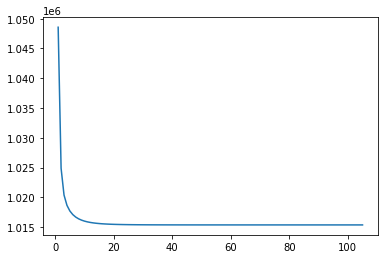

In [12]:
from matplotlib import pyplot as plt

plt.plot(f_vals)

In [13]:
b_u_hat = x_new[:num_users]
b_i_hat = x_new[num_users:]

## Train Prediction - part 1

In [15]:
train_pred_1 = []
for i, row in df.iterrows():
    user = row['user_id']
    song = row['song_id']

    user_index = users_hash[user]
    bu = b_u_hat[user_index][0]

    song_index = songs_hash[song]
    bi = b_i_hat[song_index-num_users][0]

    train_pred_1.append(r_avg + bu + bi)

In [22]:
train_pred_1 = np.maximum(train_pred_1,0)
mse_train_1 = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_pred_1),3)
sse_train_1 = np.sum(np.square(df.iloc[:,2] - train_pred_1))

print(f'MSE in Part 1 on train set: {mse_train_1}\n'
      f'SSE in Part 1 on train set: {sse_train_1}')

MSE in Part 1 on train set: 2619641.311
SSE in Part 1 on train set: 1029139187408.9514


## Test Prediction - part 1

In [34]:
test_pred_1 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']

    user_index = users_hash[user]
    bu = b_u_hat[user_index][0]

    song_index = songs_hash[song]
    bi = b_i_hat[song_index-num_users][0]
    test_pred_1.append(r_avg + bu + bi)
test_pred_1 = np.maximum(test_pred_1,0)

In [19]:
# user dictionary
users_hash = {}
for i,user in enumerate(all_users):
    users_hash[user] = i

In [20]:
# song dictionary
songs_hash = {}
for j,song in enumerate(all_songs):
    songs_hash[song] = j

In [21]:
num_users = len(all_users)  # Number of users
num_songs = len(all_songs)  # Number of songs
num_users, num_songs

(1892, 16548)

## create the ratings matrix

In [23]:
# create the sparse ratings matrix
no_zeros = pd.read_csv('user_song.csv')
R = sp.lil_matrix((num_users, num_songs))

for i, row in no_zeros.iterrows():
    # Set the nonzero entries in the current row
    user = users_hash[row['user_id']]
    song = songs_hash[row['song_id']]
    rating = row['weight']
    R[user, song] = rating

R_rows = R.tocsr()  # we'll use to slice rows
R_cols = R.tocsc()  # we'll use to slice column

In [24]:
# alternating least squares step
def als_step(latent_vectors, fixed_vecs, ratings, _lambda=0, type='user'):
    """
    One of the two ALS steps. Solve for the latent vectors
    specified by type.
    """
    if type == 'user':
        # calculating P, Q is fixed
        QTQ = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(QTQ.shape[0]) * _lambda

        for u in range(latent_vectors.shape[0]):  # iterate over P rows and R Rows
            # if u==0:
                # print(f"prev vec user {u}: {latent_vectors[u,:]}")
            new_vec = (la.solve((QTQ + lambdaI),
                                             (ratings[u, :].dot(fixed_vecs)).transpose())).ravel()
            # if u==0:
                # print(new_vec)
            latent_vectors[u, :] = new_vec

                # print(f"{np.array_equal(latent_vectors[u,:],new_vec)}")
    elif type == 'item':
        # calculating Q, P is fixed
        PTP = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(PTP.shape[0]) * _lambda

        for i in range(latent_vectors.shape[0]):
            # if i ==0:
            #     print(f"prev vec song {i}: {latent_vectors[i,:]}")
            new_vec =  (la.solve((PTP + lambdaI),
                                             (ratings[:, i].transpose().dot(fixed_vecs)).transpose())).ravel()
            # if i==0:
                # print(new_vec)
            latent_vectors[i, :] = new_vec

                # print(f"{np.array_equal(latent_vectors[i,:],new_vec)}")
    return latent_vectors

In [25]:
def als_predict_vecs(iterations = 10, k =20):
    np.random.seed(0)
    new_users = np.random.random((num_users, k))  # TODO: change to ones, but it throws an error
    new_songs = np.zeros((num_songs, k))
    old_songs, old_users = new_songs, new_users
    i = 1
    while i<iterations: #or not (np.array_equal(old_songs, new_songs) and np.array_equal(old_users, new_users)):
        old_songs, old_users = new_songs, new_users
        # print(old_songs[0,:])
        new_songs = als_step(new_songs,
                               new_users,
                               R_cols,
                               type='item')
        # print(new_songs[0,:])
        new_users = als_step(new_users,
                               new_songs,
                               R_rows,
                               type='user')
        # print(np.allclose(old_songs, new_songs,rtol=1e-03, atol=1e-03))
        print(i)
        i+=1
    return new_users, new_songs


## Train Prediction - part 2

In [35]:
# user_matrix,song_matrix = als_predict()
def predict(users, songs):
    prediction = []
    for i, row in df.iterrows():
        user = row['user_id']
        song = row['song_id']

        user_index = users_hash[user]
        song_index = songs_hash[song]

        pred = max(users[user_index, :].dot(songs[song_index, :]),0)

        prediction.append(pred)
    return prediction

In [27]:
def learning_curve_part_2(iterations):
    user_vecs, song_vecs = als_predict_vecs(iterations=iterations)
    print(f'{iterations} iterations')
    train_predictions = predict(user_vecs, song_vecs)
    mse = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_predictions), 3)
    print(mse)
    return mse

## check the learning curve

In [28]:
# iterations = (2,5,10,15,20,50,100)
# mse_list = [learning_curve_part_2(iterations=i) for i in iterations]
# plt.plot(iterations[:5], mse_list)

TypeError: 'int' object is not iterable

In [31]:
K=20
user_matrix, song_matrix = als_predict_vecs(iterations=5,k=K) # TODO: 10?, 2 works better though
train_pred_part2 = predict(user_matrix,song_matrix)
mse_train_2 = np.round(MSE(y_true=df.iloc[:,2], y_pred=train_pred_part2), 3)
sse_train_2 = np.sum(np.square(df.iloc[:,2] - train_pred_part2))
print(f'MSE in Part 2 on train set: {mse_train_2}\n'
      f'SSE in Part 2 on train set: {sse_train_2}\n'
      f'compared to part 1\n'
      f'Improvement of {mse_train_1 - mse_train_2} in the MSE\n'
      f'Improvement of {sse_train_1 - sse_train_2} in the SSE')

1
2
3
4
MSE in Part 2 on train set: 571307.876
SSE in Part 2 on train set: 224441155581.1544
compared to part 1
Improvement of 2048333.435 in the MSE
Improvement of 804698031827.797 in the SSE


## Test Prediction

In [ ]:
mean_user_entry = user_matrix.mean()
median_user_entry = np.median(user_matrix)

mean_song_entry = song_matrix.mean()
median_song_entry = np.median(song_matrix)

In [144]:
test_pred_2 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']
    user_index = users_hash[user]
    user_vec = user_matrix[user_index]
    song_index = songs_hash[song]
    song_vec = song_matrix[song_index]
    test_pred_2.append(max(user_vec.dot(song_vec),0))


# Part 3

In [37]:
# Perform SVD on the sparse matrix
# k = Number of singular values/vectors to use
U, S, V = svds(R_rows, k=20)

# Reconstruct the matrix using k singular values/vectors
reduced_R = U.dot(sp.diags(S).dot(V))



494270.1826472662

## part 3 train SSE

In [38]:
la.norm(R - reduced_R)**2

244303013454.1619

part 3 test

In [41]:
test_pred_3 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']
    user_index = users_hash[user]
    song_index = songs_hash[song]
    test_pred_3.append(max(reduced_R[user_index,song_index],0))

# ??

In [173]:
from sklearn.decomposition import TruncatedSVD
movie_svd = TruncatedSVD(n_components=20)
movie_features = movie_svd.fit_transform(R_rows)
movie_features


array([[ 1.61986513e+02,  8.16646444e-01,  4.15984691e+01, ...,
         1.74729460e+01, -2.21394839e+01,  1.45697821e+01],
       [ 9.83777088e-01,  1.04461350e-01,  2.58215767e-01, ...,
        -2.58216215e-01,  7.63471391e-01,  1.75510303e+00],
       [ 1.72788891e+03,  2.87772251e+00,  5.79312401e+01, ...,
        -5.16097506e+00,  1.75152615e+02, -2.76223694e+01],
       ...,
       [ 4.91562118e+00,  1.20800706e+01,  2.17293498e+03, ...,
        -1.99362494e+02, -4.39169951e+02,  1.83718364e+03],
       [ 2.32986067e+00,  1.15089461e+01,  5.04095525e+02, ...,
         2.63574394e+01,  2.70538707e+02, -5.24158997e+01],
       [ 5.74155471e+00,  3.02752030e+01,  1.36511058e+03, ...,
        -4.46342309e+01,  2.22556927e+02,  2.02332855e+02]])

In [174]:
R_rows

<1891x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 80602 stored elements in Compressed Sparse Row format>